In [396]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [437]:
df_train = pd.read_csv("../../Data/Final_train.csv")

In [438]:
df_train.info()
df = df_train.copy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1647 entries, 0 to 1646
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Year                            1647 non-null   int64  
 1   Kilometer                       1647 non-null   float64
 2   Length                          1647 non-null   float64
 3   Width                           1647 non-null   float64
 4   Height                          1647 non-null   float64
 5   Fuel Tank Capacity              1647 non-null   float64
 6   Log_Price                       1647 non-null   float64
 7   Engine_Value                    1647 non-null   float64
 8   Max_Power_Value                 1647 non-null   float64
 9   Max_Power_RPM                   1647 non-null   float64
 10  Max_Torque_Value                1647 non-null   float64
 11  Max_Torque_RPM                  1647 non-null   float64
 12  Make_encoded                    16

In [439]:
# df['log_Max_Power'] = np.log1p(df['Max_Power_Value'])  # log(1+x) để tránh log(0)
# df['log_Max_Torque'] = np.log1p(df['Max_Torque_Value'])
# df['sqrt_Max_Power'] = np.sqrt(df['Max_Power_Value'])
# df['sqrt_Max_Torque'] = np.sqrt(df['Max_Torque_Value'])

# 2. Biến tương tác
df['Volume'] = df['Length'] * df['Width'] * df['Height']
df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume']
df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity']

# 3. Tương tác RPM
df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM']
df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM']

# 4. Tỷ lệ Power/Torque
df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value']
df['Length_Width_interaction'] = df['Length'] * df['Width']

In [440]:
df_train = df

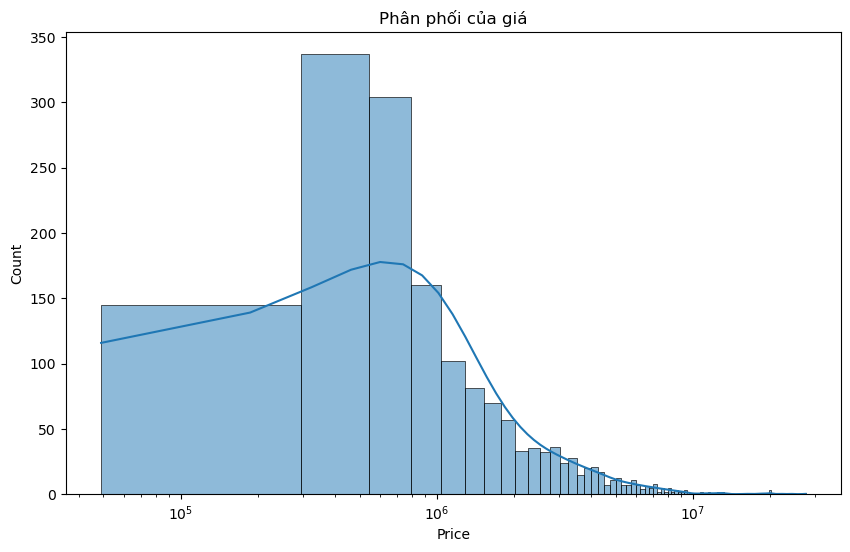

Ngưỡng giá để xác định outlier: 17586000.00
Số dòng đã loại bỏ: 9
Số lượng đặc trưng float64: 18
Nhóm Fuel: 3 cột
Nhóm Transmission: 1 cột
Nhóm Color: 5 cột
Nhóm Owner: 5 cột
Nhóm Seller: 2 cột
Nhóm Seating: 5 cột
Tổng số lượng đặc trưng categorical (int64): 21
Kích thước tập train: (1310, 39)
Kích thước tập test: (328, 39)
Các đặc trưng float64 tốt nhất:
                     Feature        Score        P-value
14             Power_Density  2463.112366  4.856229e-303
6            Max_Power_Value  2350.095466  2.148450e-294
8           Max_Torque_Value  2239.412140  1.154770e-285
17  Length_Width_interaction  2194.079609  5.213674e-282
10              Make_encoded  2023.910197  7.441229e-268

Các nhóm đặc trưng categorical (int64) tốt nhất:
1. Nhóm Transmission: R2 = 0.4278, Số đặc trưng: 1
2. Nhóm Fuel: R2 = 0.1581, Số đặc trưng: 3
3. Nhóm Color: R2 = 0.1023, Số đặc trưng: 5
4. Nhóm Seating: R2 = 0.0784, Số đặc trưng: 5
5. Nhóm Owner: R2 = 0.0310, Số đặc trưng: 5
6. Nhóm Seller: R2 = 0

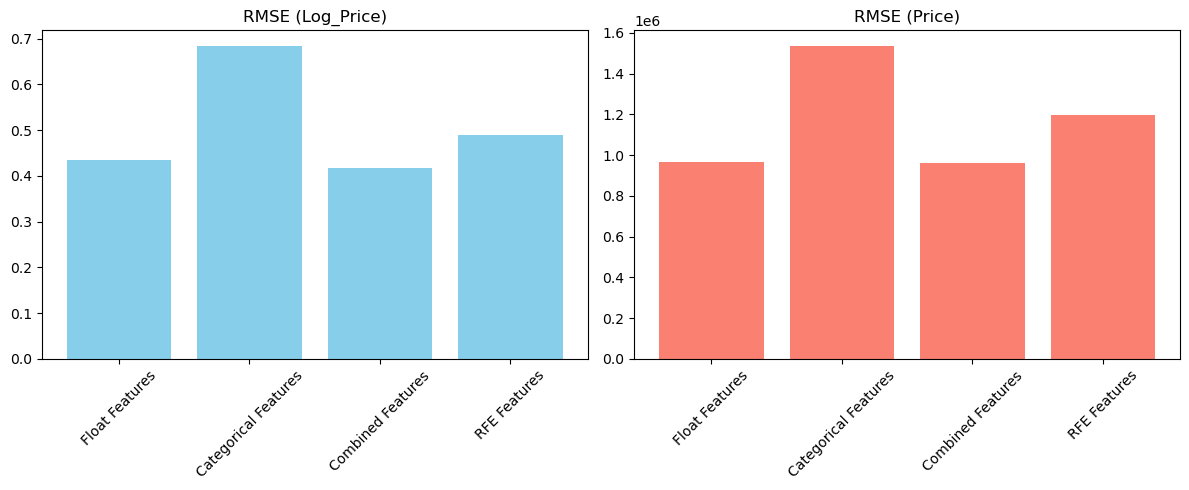

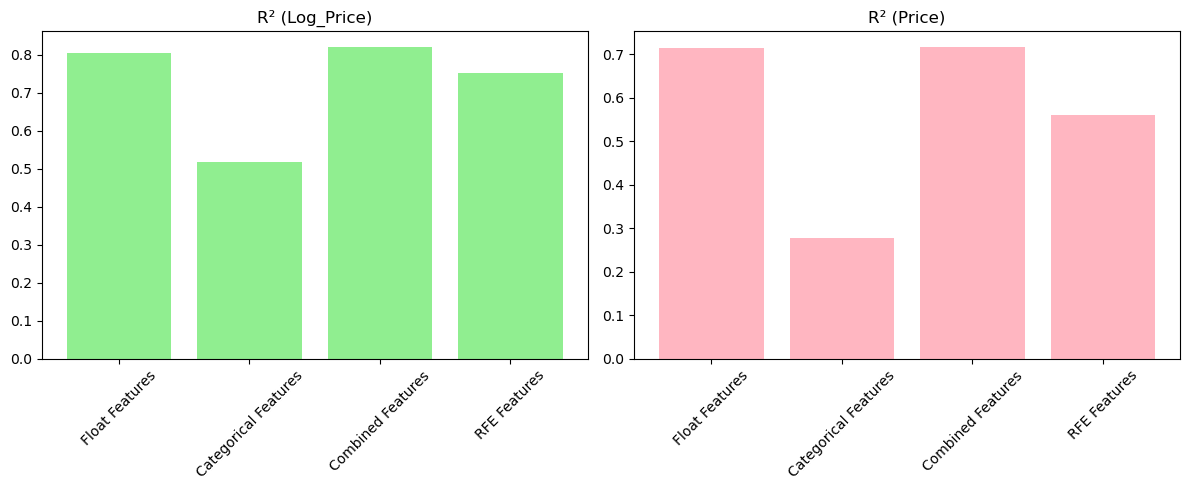

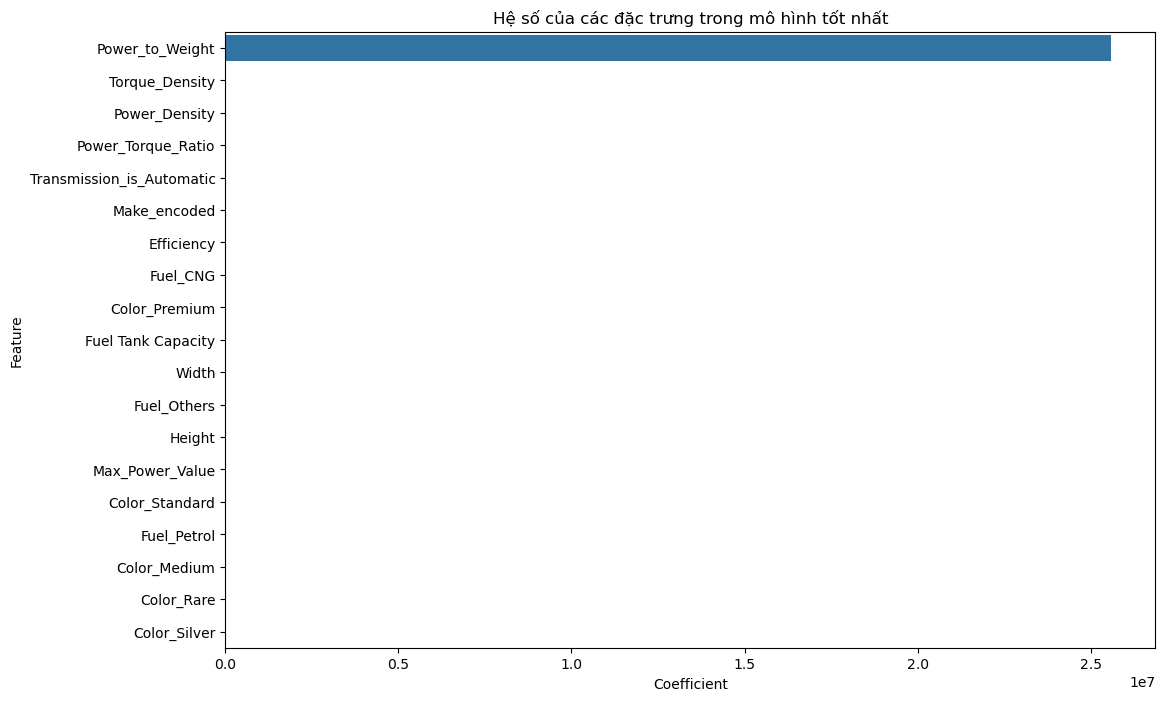

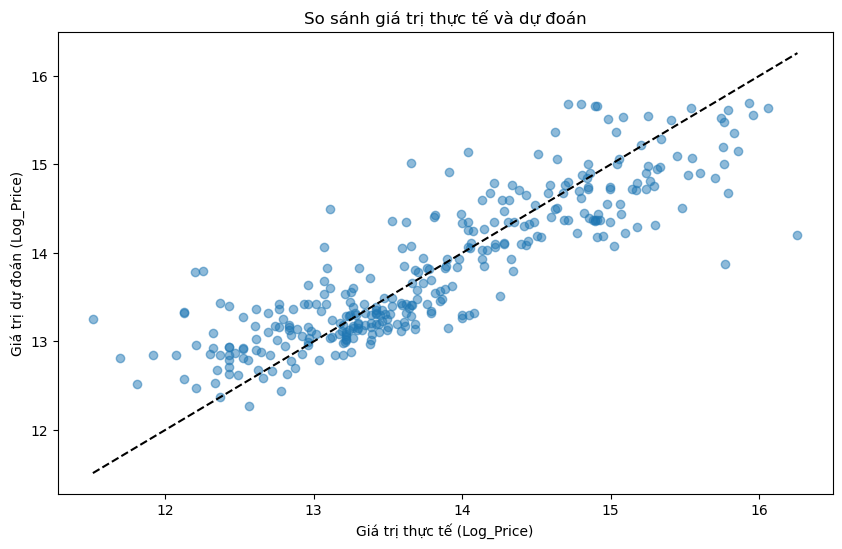

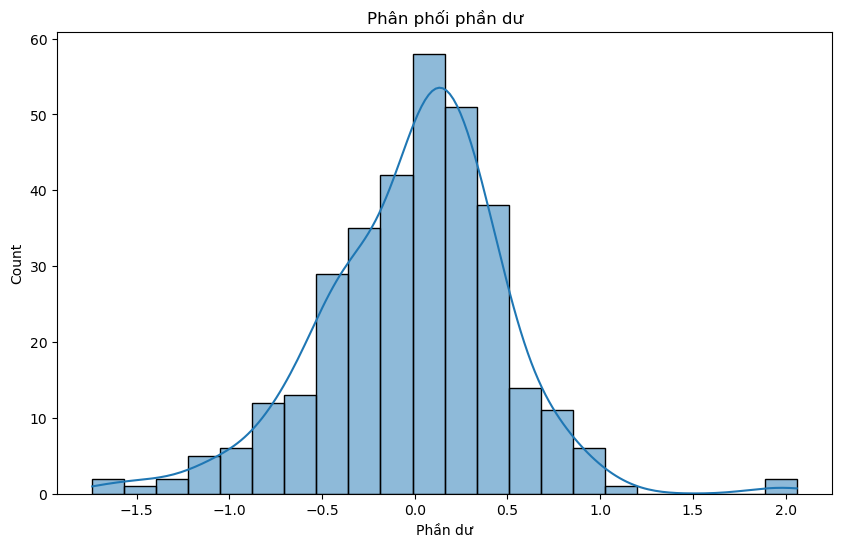

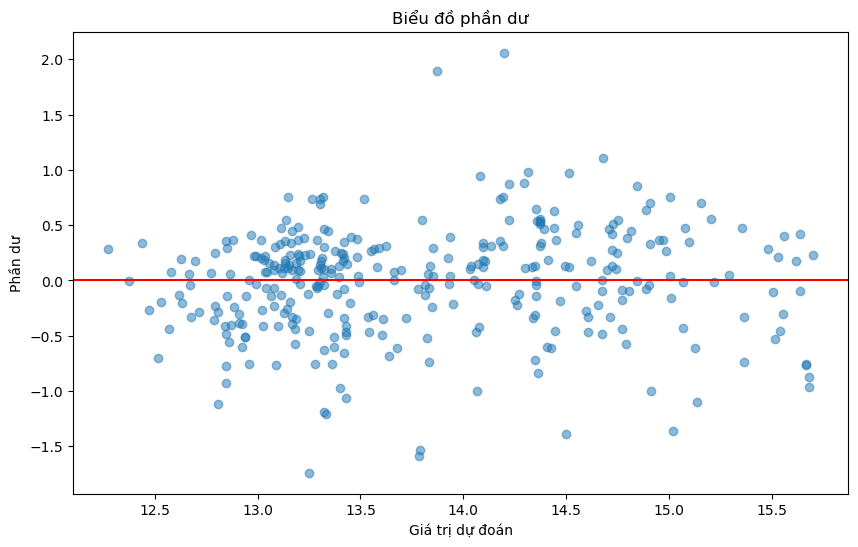

In [443]:
# Cell 1: Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Cell 2: Xử lý dữ liệu ban đầu
# Giả sử df_train đã được tải vào
# Tạo cột Price từ Log_Price
df_train['Price'] = np.exp(df_train['Log_Price'])

# Hiển thị phân phối của Price
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Price'], kde=True)
plt.title('Phân phối của giá')
plt.xscale('log')
plt.show()

# Cell 3: Loại bỏ các outlier
# Tính toán ngưỡng để xác định outlier (ví dụ: giá cao hơn 99.5%)
price_threshold = df_train['Price'].quantile(0.995)
print(f"Ngưỡng giá để xác định outlier: {price_threshold:.2f}")

# Loại bỏ các dòng có giá quá cao
df_clean = df_train[df_train['Price'] <= price_threshold].copy()
print(f"Số dòng đã loại bỏ: {len(df_train) - len(df_clean)}")

# Cell 4: Phân chia các cột theo loại dữ liệu
# Lấy các cột float64 (dữ liệu số thực)
float_columns = df_clean.select_dtypes(include=['float64']).columns.tolist()
# Loại bỏ cột target và Price từ danh sách đặc trưng
float_features = [col for col in float_columns if col not in ['Log_Price', 'Price']]
print(f"Số lượng đặc trưng float64: {len(float_features)}")

# Lấy các cột int64 (các cột categorical đã được one-hot)
int_columns = df_clean.select_dtypes(include=['int64']).columns.tolist()

# Nhóm các cột categorical theo prefix
categorical_groups = {}
for col in int_columns:
    prefix = col.split('_')[0] if '_' in col else None
    if prefix:
        if prefix not in categorical_groups:
            categorical_groups[prefix] = []
        categorical_groups[prefix].append(col)

# In ra các nhóm categorical
for prefix, cols in categorical_groups.items():
    print(f"Nhóm {prefix}: {len(cols)} cột")

# Lọc các cột categorical (dạng Fuel_%, Seating_%, etc.)
categorical_features = [col for col in int_columns if '_' in col]
print(f"Tổng số lượng đặc trưng categorical (int64): {len(categorical_features)}")

# Cell 5: Chia tập dữ liệu
X = df_clean[float_features + categorical_features]
y = df_clean['Log_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Kích thước tập train: {X_train.shape}")
print(f"Kích thước tập test: {X_test.shape}")

# Cell 6: Lựa chọn đặc trưng float64 tốt nhất
# Sử dụng SelectKBest với f_regression để chọn các đặc trưng
def select_best_float_features(X_train_float, y_train, k=10):
    selector = SelectKBest(f_regression, k=min(k, len(X_train_float.columns)))
    selector.fit(X_train_float, y_train)
    
    # Lấy điểm số và p-value
    scores = selector.scores_
    p_values = selector.pvalues_
    
    # Tạo DataFrame để hiển thị kết quả
    feature_scores = pd.DataFrame({
        'Feature': X_train_float.columns,
        'Score': scores,
        'P-value': p_values
    })
    
    # Sắp xếp theo điểm số giảm dần
    feature_scores = feature_scores.sort_values('Score', ascending=False)
    
    # Chọn k đặc trưng tốt nhất
    best_features = feature_scores.head(k)['Feature'].tolist()
    
    return best_features, feature_scores

# Áp dụng cho đặc trưng float64
X_train_float = X_train[float_features]
best_float_features, float_scores = select_best_float_features(X_train_float, y_train, k=55)

print("Các đặc trưng float64 tốt nhất:")
print(float_scores.head(5))

# Cell 7: Lựa chọn đặc trưng categorical (int64) tốt nhất theo nhóm
def select_best_categorical_groups(X_train, y_train, categorical_groups):
    # Tạo một LinearRegression model
    model = LinearRegression()
    
    # Danh sách để lưu các kết quả
    group_scores = []
    
    # Đánh giá mỗi nhóm categorical
    for prefix, cols in categorical_groups.items():
        if len(cols) > 0:
            # Tính toán r2 cho nhóm này
            model.fit(X_train[cols], y_train)
            r2 = r2_score(y_train, model.predict(X_train[cols]))
            
            group_scores.append({
                'Group': prefix,
                'R2_Score': r2,
                'Num_Features': len(cols),
                'Features': cols
            })
    
    # Sắp xếp theo điểm R2 giảm dần
    group_scores = sorted(group_scores, key=lambda x: x['R2_Score'], reverse=True)
    
    return group_scores

# Áp dụng cho đặc trưng categorical
categorical_groups = {}
for col in categorical_features:
    prefix = col.split('_')[0]
    if prefix not in categorical_groups:
        categorical_groups[prefix] = []
    categorical_groups[prefix].append(col)

# Chọn những nhóm categorical tốt nhất
best_cat_groups = select_best_categorical_groups(X_train, y_train, categorical_groups)

print("\nCác nhóm đặc trưng categorical (int64) tốt nhất:")
for i, group_info in enumerate(best_cat_groups):
    print(f"{i+1}. Nhóm {group_info['Group']}: R2 = {group_info['R2_Score']:.4f}, Số đặc trưng: {group_info['Num_Features']}")

# Lấy top nhóm tốt nhất
top_n_groups = 3  # Số nhóm tốt nhất cần lấy
best_cat_features = []
for i in range(min(top_n_groups, len(best_cat_groups))):
    best_cat_features.extend(best_cat_groups[i]['Features'])

print(f"\nTổng số đặc trưng categorical được chọn: {len(best_cat_features)}")

# Cell 8: Huấn luyện mô hình với đặc trưng float64 tốt nhất
def train_and_evaluate_model(X_train, X_test, y_train, y_test, features):
    # Chọn đặc trưng
    X_train_selected = X_train[features]
    X_test_selected = X_test[features]
    
    # Huấn luyện mô hình
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    
    # Dự đoán
    y_pred = model.predict(X_test_selected)
    
    # Đánh giá trên Log_Price
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Đánh giá trên Price (chuyển đổi từ Log_Price)
    y_test_exp = np.exp(y_test)
    y_pred_exp = np.exp(y_pred)
    
    mse_exp = mean_squared_error(y_test_exp, y_pred_exp)
    rmse_exp = np.sqrt(mse_exp)
    mae_exp = mean_absolute_error(y_test_exp, y_pred_exp)
    r2_exp = r2_score(y_test_exp, y_pred_exp)
    
    # In kết quả
    print(f"Số lượng đặc trưng: {len(features)}")
    print(f"Các đặc trưng được sử dụng: {features}")
    print("\nKết quả đánh giá trên Log_Price:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R^2: {r2:.4f}")
    
    print("\nKết quả đánh giá trên Price:")
    print(f"MSE: {mse_exp:.4f}")
    print(f"RMSE: {rmse_exp:.4f}")
    print(f"MAE: {mae_exp:.4f}")
    print(f"R^2: {r2_exp:.4f}")
    
    return model, (mse, rmse, mae, r2), (mse_exp, rmse_exp, mae_exp, r2_exp)

# Huấn luyện mô hình với đặc trưng float64 tốt nhất
print("Kết quả mô hình với đặc trưng float64 tốt nhất:")
model_float, metrics_float_log, metrics_float_exp = train_and_evaluate_model(
    X_train, X_test, y_train, y_test, best_float_features
)

# Cell 9: Huấn luyện mô hình với đặc trưng categorical (int64) tốt nhất
print("\nKết quả mô hình với đặc trưng categorical (int64) tốt nhất:")
model_cat, metrics_cat_log, metrics_cat_exp = train_and_evaluate_model(
    X_train, X_test, y_train, y_test, best_cat_features
)

# Cell 10: Kết hợp các đặc trưng tốt nhất từ cả float64 và int64
combined_features = best_float_features + best_cat_features
print("\nKết quả mô hình với đặc trưng kết hợp (float64 + nhóm categorical tốt nhất):")
print(f"Tổng số đặc trưng kết hợp: {len(combined_features)}")
model_combined, metrics_combined_log, metrics_combined_exp = train_and_evaluate_model(
    X_train, X_test, y_train, y_test, combined_features
)

# Cell 11: Sử dụng RFE để chọn đặc trưng tốt nhất từ tất cả các đặc trưng, 
# cố gắng giữ nguyên các nhóm categorical
def select_features_with_rfe(X_train, y_train, n_features=20, cat_groups=None):
    # Sử dụng RFE với LinearRegression
    model = LinearRegression()
    
    if cat_groups is None:
        # Phương pháp thông thường nếu không có cat_groups
        rfe = RFE(model, n_features_to_select=min(n_features, X_train.shape[1]))
        rfe.fit(X_train, y_train)
        
        # Lấy các đặc trưng được chọn
        features = X_train.columns[rfe.support_].tolist()
        
        # In thông tin về thứ hạng của các đặc trưng
        feature_ranking = pd.DataFrame({
            'Feature': X_train.columns,
            'Ranking': rfe.ranking_
        })
        feature_ranking = feature_ranking.sort_values('Ranking')
    else:
        # Xác định các nhóm categorical và float features
        float_cols = [col for col in X_train.columns if not any(col in group for group in cat_groups.values())]
        
        # Đánh giá từng nhóm categorical
        group_scores = []
        for prefix, cols in cat_groups.items():
            if len(cols) > 0 and all(col in X_train.columns for col in cols):
                # Tính toán r2 cho nhóm này
                model.fit(X_train[cols], y_train)
                r2 = r2_score(y_train, model.predict(X_train[cols]))
                
                group_scores.append({
                    'Group': prefix,
                    'R2_Score': r2,
                    'Num_Features': len(cols),
                    'Features': cols
                })
        
        # Sắp xếp nhóm theo R2
        group_scores = sorted(group_scores, key=lambda x: x['R2_Score'], reverse=True)
        
        # Chọn số lượng nhóm tốt nhất để tổng số đặc trưng không vượt quá n_features
        selected_groups = []
        selected_features = []
        
        # Áp dụng RFE cho float features để chọn top n_features/2
        if float_cols:
            float_X = X_train[float_cols]
            n_float_to_select = min(n_features // 2, len(float_cols))
            float_rfe = RFE(model, n_features_to_select=n_float_to_select)
            float_rfe.fit(float_X, y_train)
            selected_float = [float_cols[i] for i, selected in enumerate(float_rfe.support_) if selected]
            selected_features.extend(selected_float)
        
        # Thêm các nhóm categorical tốt nhất
        remaining_features = n_features - len(selected_features)
        for group_info in group_scores:
            if remaining_features >= group_info['Num_Features']:
                selected_groups.append(group_info['Group'])
                selected_features.extend(group_info['Features'])
                remaining_features -= group_info['Num_Features']
            
            if remaining_features <= 0:
                break
        
        # Tạo bảng xếp hạng (coi như các đặc trưng được chọn có thứ hạng 1, còn lại là 2)
        feature_ranking = pd.DataFrame({
            'Feature': X_train.columns,
            'Ranking': [1 if feat in selected_features else 2 for feat in X_train.columns],
            'Category': [next((group for group, cols in cat_groups.items() if feat in cols), 'Numeric') 
                         for feat in X_train.columns]
        })
        feature_ranking = feature_ranking.sort_values('Ranking')
        
        features = selected_features
        
        print(f"Các nhóm categorical được chọn: {selected_groups}")
        print(f"Số đặc trưng float được chọn: {len([f for f in selected_features if f in float_cols])}")
        print(f"Số đặc trưng categorical được chọn: {len([f for f in selected_features if f not in float_cols])}")
    
    return features, feature_ranking

# Áp dụng RFE cho tất cả các đặc trưng, giữ nguyên cấu trúc các nhóm categorical
all_features = float_features + categorical_features
X_train_all = X_train[all_features]

# Xây dựng lại categorical_groups
categorical_groups = {}
for col in categorical_features:
    prefix = col.split('_')[0]
    if prefix not in categorical_groups:
        categorical_groups[prefix] = []
    categorical_groups[prefix].append(col)

best_mixed_features, feature_ranking = select_features_with_rfe(
    X_train_all, y_train, n_features=20, cat_groups=categorical_groups
)

print("\nTop 20 đặc trưng được chọn bởi RFE phiên bản sửa đổi:")
print(feature_ranking.head(20))

# Cell 12: Huấn luyện mô hình với đặc trưng kết hợp được chọn bởi RFE
print("\nKết quả mô hình với đặc trưng kết hợp được chọn bởi RFE:")
model_rfe, metrics_rfe_log, metrics_rfe_exp = train_and_evaluate_model(
    X_train, X_test, y_train, y_test, best_mixed_features
)

# Cell 13: So sánh các mô hình
models = ['Float Features', 'Categorical Features', 'Combined Features', 'RFE Features']
rmse_log_values = [metrics_float_log[1], metrics_cat_log[1], metrics_combined_log[1], metrics_rfe_log[1]]
rmse_exp_values = [metrics_float_exp[1], metrics_cat_exp[1], metrics_combined_exp[1], metrics_rfe_exp[1]]
r2_log_values = [metrics_float_log[3], metrics_cat_log[3], metrics_combined_log[3], metrics_rfe_log[3]]
r2_exp_values = [metrics_float_exp[3], metrics_cat_exp[3], metrics_combined_exp[3], metrics_rfe_exp[3]]

# Vẽ biểu đồ so sánh RMSE
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models, rmse_log_values, color='skyblue')
plt.title('RMSE (Log_Price)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models, rmse_exp_values, color='salmon')
plt.title('RMSE (Price)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ so sánh R²
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(models, r2_log_values, color='lightgreen')
plt.title('R² (Log_Price)')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(models, r2_exp_values, color='lightpink')
plt.title('R² (Price)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Cell 14: Phân tích và trực quan hóa mô hình tốt nhất (RFE Features)
# Lấy hệ số của mô hình
best_model = model_rfe
coef = pd.DataFrame({
    'Feature': best_mixed_features,
    'Coefficient': best_model.coef_
})
coef = coef.sort_values('Coefficient', ascending=False)

# Vẽ biểu đồ hệ số
plt.figure(figsize=(12, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef)
plt.title('Hệ số của các đặc trưng trong mô hình tốt nhất')
plt.show()

# Trực quan hóa giá trị thực tế và dự đoán
plt.figure(figsize=(10, 6))
plt.scatter(y_test, model_rfe.predict(X_test[best_mixed_features]), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Giá trị thực tế (Log_Price)')
plt.ylabel('Giá trị dự đoán (Log_Price)')
plt.title('So sánh giá trị thực tế và dự đoán')
plt.show()

# Phân tích phần dư
residuals = y_test - model_rfe.predict(X_test[best_mixed_features])
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Phân phối phần dư')
plt.xlabel('Phần dư')
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(model_rfe.predict(X_test[best_mixed_features]), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Phần dư')
plt.title('Biểu đồ phần dư')
plt.show()

In [447]:
df_train.columns

Index(['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity',
       'Log_Price', 'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM',
       'Max_Torque_Value', 'Max_Torque_RPM', 'Make_encoded', 'Fuel_CNG',
       'Fuel_Others', 'Fuel_Petrol', 'Transmission_is_Automatic',
       'Color_Medium', 'Color_Premium', 'Color_Rare', 'Color_Silver',
       'Color_Standard', 'Owner_First_Owner', 'Owner_Fourth_Plus_Owner',
       'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner',
       'Seller_Commercial Registration', 'Seller_Corporate', 'Seating_2',
       'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'],
      dtype='object')

In [ ]:
    # 'Year', 
    # 'Kilometer', 
    # 'Length', 
    # # 'Width', 
    # # 'Height', 
    # 'Fuel Tank Capacity',
    # # 'Engine_Value', 
    # 'Max_Power_Value', 
    # 'Max_Power_RPM',
    # 'Max_Torque_Value', 
    # # 'Max_Torque_RPM', 
    # 'Make_encoded',

    # 'Fuel_CNG',
    # 'Fuel_Others', 
    # 'Fuel_Petrol', 

    # 'Transmission_is_Automatic',

    # # 'Volume',
    # # 'Power_to_Weight',
    # 'Efficiency',
    # # 'Power_Density',
    # # 'Torque_Density',
    # 'Power_Torque_Ratio',
    # # 'Length_Width_interaction',


    # 'Color_Medium', 
    # 'Color_Premium', 
    # 'Color_Rare', 
    # 'Color_Silver',
    # 'Color_Standard', 
    
    # 'Owner_First_Owner', 
    # 'Owner_Fourth_Plus_Owner',
    # 'Owner_New', 
    # 'Owner_Second_Owner', 
    # 'Owner_Third_Owner',

    # 'Seller_Commercial Registration', 
    # 'Seller_Corporate', 
    
    # 'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'

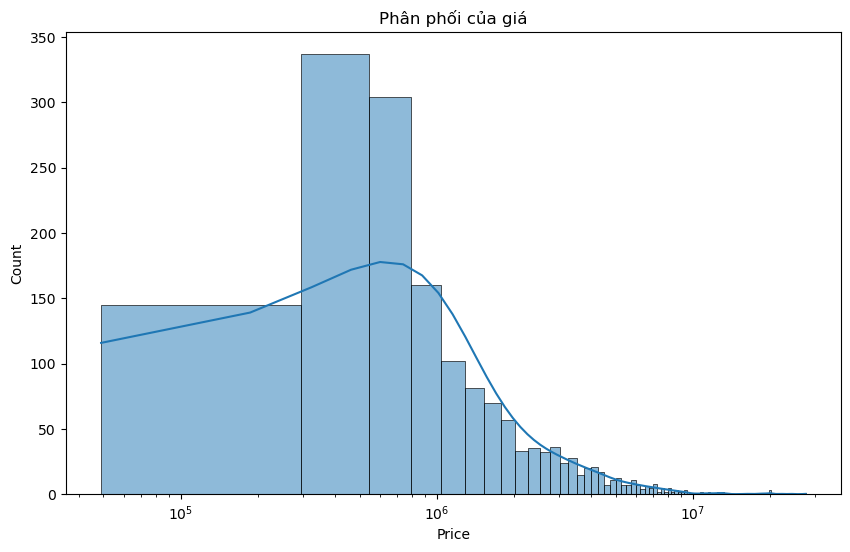

Ngưỡng giá để xác định outlier: 11224000.00
Số dòng đã loại bỏ: -8
Feature weights:
Year: 0.1196
Kilometer: -0.1327
Length: 0.1561
Fuel Tank Capacity: 0.0755
Max_Power_Value: 0.2521
Max_Power_RPM: 0.0667
Max_Torque_Value: -0.0594
Make_encoded: 0.2774
Fuel_CNG: -0.1098
Fuel_Others: 0.1418
Fuel_Petrol: -0.2155
Transmission_is_Automatic: 0.2284
Volume: -0.0000
Efficiency: -0.0010
Age_Volume: 0.0000
Age_Kilometer: 0.0007
Kilometer_per_Year: 0.6117
Power_to_CC: 0.0831
Power_to_Torque: -0.0300
RPM_Ratio: -0.0597
Owner_First_Owner: 0.1299
Owner_Fourth_Plus_Owner: -0.5038
Owner_New: 0.2759
Owner_Second_Owner: 0.0939
Owner_Third_Owner: 0.0041
Seating_2: 0.9129
Seating_4: 0.1141
Seating_6: 0.0298
Seating_7: 0.0390
Seating_8: -0.0344
Intercept: -227.5309

Metrics for Log_Price:
MSE: 0.0857
MAE: 0.1849
R^2: 0.8940

Metrics for Actual Price (exponentiated):
MSE: 276267655106.1226
MAE: 258913.3541
R^2: 0.8540


In [606]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Đọc dữ liệu
df_train = pd.read_csv('../../Data/Final_train.csv')
df_train['Price'] = np.exp(df_train['Log_Price'])

# Hiển thị phân phối của Price
plt.figure(figsize=(10, 6))
sns.histplot(df_train['Price'], kde=True)
plt.title('Phân phối của giá')
plt.xscale('log')
plt.show()

# Cell 3: Loại bỏ các outlier
# Tính toán ngưỡng để xác định outlier (ví dụ: giá cao hơn 99.5%)
price_threshold = df_train['Price'].quantile(0.99)
print(f"Ngưỡng giá để xác định outlier: {price_threshold:.2f}")

# Loại bỏ các dòng có giá quá cao
df_train = df_train[df_train['Price'] <= price_threshold].copy()
print(f"Số dòng đã loại bỏ: {len(df_train) - len(df_clean)}")
df = df_train.copy()
df['Volume'] = df_train['Length'] * df_train['Width'] * df_train['Height']
df['Power_to_Weight'] = df['Max_Power_Value'] / df['Volume']
df['Efficiency'] = df['Max_Power_Value'] / df['Fuel Tank Capacity']

# 3. Tương tác RPM
df['Power_Density'] = df['Max_Power_Value'] / df['Max_Power_RPM']
df['Torque_Density'] = df['Max_Torque_Value'] / df['Max_Torque_RPM']

# 4. Tỷ lệ Power/Torque
df['Power_Torque_Ratio'] = df['Max_Power_Value'] / df['Max_Torque_Value']
df['Length_Width_interaction'] = df['Length'] * df['Width']
df['Kilometer_Log'] = np.log(df['Kilometer'] - df['Kilometer'].min() + 1e-3)
df_train = df

for col in ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity', 
           'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 'Max_Torque_RPM']:
    if col in df_train.columns:
        # Biến đổi logarithm: hữu ích cho các biến dạng phân phối skewed
        try:   
            df_train[f'{col}_log'] = np.log1p(df_train[col].clip(lower=0.001))
        except:
            print(f"Error while creating log {col}")
        
        # Biến đổi bình phương: capture mối quan hệ phi tuyến
        df_train[f'{col}_squared'] = df_train[col]**2

# FEATFEAT
df_train['Volume'] = df_train['Length'] * df_train['Width'] * df_train['Height']
df_train['Age'] = 2025 - df_train['Year']
df_train['Age_Volume'] = df_train['Age'] * df_train['Volume']
df_train['Age_Kilometer'] = df_train['Age'] * df_train['Kilometer']
df_train['Kilometer_per_Year'] = df_train['Kilometer'] / df_train['Age'].clip(lower=1)

# 3. Các tỉ lệ kỹ thuật quan trọng
df_train['Power_to_Weight'] = df_train['Max_Power_Value'] / df_train['Volume'].clip(lower=1)
df_train['Power_to_CC'] = df_train['Max_Power_Value'] / df_train['Engine_Value'].clip(lower=1)
df_train['Torque_to_CC'] = df_train['Max_Torque_Value'] / df_train['Engine_Value'].clip(lower=1)
df_train['Power_to_Torque'] = df_train['Max_Power_Value'] / df_train['Max_Torque_Value'].clip(lower=1)
df_train['RPM_Ratio'] = df_train['Max_Power_RPM'] / df_train['Max_Torque_RPM'].clip(lower=1)

# 4. Các biến phi tuyến phức tạp (capturing domain knowledge)
df_train['Efficiency_Index'] = df_train['Max_Power_Value'] / (df_train['Engine_Value'] * df_train['Fuel Tank Capacity']).clip(lower=1)
df_train['Performance_Index'] = (df_train['Max_Power_Value'] * df_train['Max_Torque_Value']) / df_train['Engine_Value'].clip(lower=1)
df_train['Luxury_Index'] = df_train['Volume'] * df_train['Max_Power_Value'] / 1000
df_train['Size_Ratio'] = df_train['Length'] / df_train['Width'].clip(lower=1)
df_train['Space_Efficiency'] = df_train['Volume'] / df_train['Engine_Value'].clip(lower=1)

# 5. Polynomial features cho các biến kỹ thuật quan trọng
df_train['Power_Polynomial'] = df_train['Max_Power_Value']**2 / df_train['Engine_Value'].clip(lower=1)
df_train['Mileage_Decay'] = np.exp(-df_train['Kilometer'] / 100000)  # Hiệu ứng giảm giá theo số km theo hàm mũ
df_train['Premium_Power'] = df_train['Max_Power_Value'] * (df_train['Make_encoded'] > 5).astype(int)  # Tương tác giữa hãng cao cấp và công suất


# Chọn các features (THAY ĐỔI FEATURES Ở ĐÂY)
selected_features = [
    'Year', 
    # 'Year_squared',
    # 'Year_log',
    # 'Kilometer_Log',
    'Kilometer', 
    # 'Kilometer_squared',
    'Length', 
    # 'Width', 
    # 'Height', 
    # 'Height_squared',
    'Fuel Tank Capacity',
    # 'Engine_Value', 
    'Max_Power_Value', 
    'Max_Power_RPM',
    'Max_Torque_Value', 
    # 'Max_Torque_RPM', 
    'Make_encoded',

    'Fuel_CNG',
    'Fuel_Others', 
    'Fuel_Petrol', 

    'Transmission_is_Automatic',

    'Volume',
    # 'Power_to_Weight',
    'Efficiency',
    # 'Power_Density',
    # 'Torque_Density',
    # 'Power_Torque_Ratio',
    # 'Length_Width_interaction',
    # 'Age',
    'Age_Volume',
    'Age_Kilometer',
    'Kilometer_per_Year',
    'Power_to_CC',
    # 'Torque_to_CC',
    'Power_to_Torque',
    'RPM_Ratio',
    # 'Efficiency_Index',
    # 'Performance_Index',
    # 'Luxury_Index',
    # 'Size_Ratio', # bo
    # 'Space_Efficiency', # bo
    # 'Power_Polynomial', # bo
    # 'Mileage_Decay', # bo
    # 'Premium_Power', # bo

    # 'Color_Medium', 
    # 'Color_Premium', 
    # 'Color_Rare', 
    # 'Color_Silver',
    # 'Color_Standard', 
    
    'Owner_First_Owner', 
    'Owner_Fourth_Plus_Owner',
    'Owner_New', 
    'Owner_Second_Owner', 
    'Owner_Third_Owner',

    # 'Seller_Commercial Registration', 
    # 'Seller_Corporate', 
    
    'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8'
]

# Tạo X và y
X = df_train[selected_features]
y = df_train['Log_Price']

# Chia dữ liệu thành tập train và test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit mô hình
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập test
y_pred = model.predict(X_test)

# Tính toán các metrics cho Log_Price
mse_log = mean_squared_error(y_test, y_pred)
mae_log = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# In ra weights của mô hình
print("Feature weights:")
for feature, weight in zip(selected_features, model.coef_):
    print(f"{feature}: {weight:.4f}")
print(f"Intercept: {model.intercept_:.4f}")

# In ra các metrics cho Log_Price
print("\nMetrics for Log_Price:")
print(f"MSE: {mse_log:.4f}")
print(f"MAE: {mae_log:.4f}")
print(f"R^2: {r2:.4f}")

# Chuyển từ Log_Price sang Price thực tế (exp của Log_Price)
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Tính toán các metrics cho Price thực tế
mse_actual = mean_squared_error(y_test_exp, y_pred_exp)
mae_actual = mean_absolute_error(y_test_exp, y_pred_exp)
r2_actual = r2_score(y_test_exp, y_pred_exp)

# In ra các metrics cho Price thực tế
print("\nMetrics for Actual Price (exponentiated):")
print(f"MSE: {mse_actual:.4f}")
print(f"MAE: {mae_actual:.4f}")
print(f"R^2: {r2_actual:.4f}")

# Visualize predictions vs actual (uncomment nếu bạn muốn vẽ biểu đồ)
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 6))
# plt.scatter(y_test, y_pred, alpha=0.5)
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
# plt.xlabel('Actual Log Price')
# plt.ylabel('Predicted Log Price')
# plt.title('Actual vs Predicted Log Price')
# plt.savefig('prediction_plot.png')
# plt.show()

In [501]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import itertools
from tqdm import tqdm

# Đọc dữ liệu
df_train = pd.read_csv('../../Data/Final_train.csv')

# Thêm các features mới (feature engineering)
df_train['Volume'] = df_train['Length'] * df_train['Width'] * df_train['Height']
df_train['Power_to_Weight'] = df_train['Max_Power_Value'] / df_train['Volume']
df_train['Efficiency'] = df_train['Max_Power_Value'] / df_train['Engine_Value']
df_train['Power_Density'] = df_train['Max_Power_Value'] / df_train['Engine_Value']
df_train['Torque_Density'] = df_train['Max_Torque_Value'] / df_train['Engine_Value']
df_train['Power_Torque_Ratio'] = df_train['Max_Power_Value'] / df_train['Max_Torque_Value']
df_train['Length_Width_interaction'] = df_train['Length'] * df_train['Width']

# Định nghĩa các nhóm features
float_features = [
    'Year', 'Kilometer', 'Length', 'Width', 'Height', 'Fuel Tank Capacity',
    'Engine_Value', 'Max_Power_Value', 'Max_Power_RPM', 'Max_Torque_Value', 
    'Max_Torque_RPM', 'Make_encoded', 'Fuel_CNG', 'Fuel_Others', 'Fuel_Petrol', 
    'Transmission_is_Automatic', 'Volume', 'Power_to_Weight', 'Efficiency',
    'Power_Density', 'Torque_Density', 'Power_Torque_Ratio', 'Length_Width_interaction'
]

categorical_groups = {
    'color': ['Color_Medium', 'Color_Premium', 'Color_Rare', 'Color_Silver', 'Color_Standard'],
    'owner': ['Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner'],
    'seller': ['Seller_Commercial Registration', 'Seller_Corporate'],
    'seating': ['Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8']
}

# Hàm đánh giá một tập features
def evaluate_feature_set(features, df, random_state=42):
    X = df[features]
    y = df['Log_Price']
    
    # Chia dữ liệu thành tập train và test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Fit mô hình
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Dự đoán và đánh giá
    y_pred = model.predict(X_test)
    
    # Chuyển từ Log_Price sang Price thực tế
    y_test_exp = np.exp(y_test)
    y_pred_exp = np.exp(y_pred)
    
    # Tính MAE trên giá trị thực tế
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    
    return mae

# Tạo các tổ hợp của các nhóm categorical
categorical_combinations = []
for i in range(len(categorical_groups) + 1):
    for combo in itertools.combinations(categorical_groups.keys(), i):
        feature_set = []
        for group_name in combo:
            feature_set.extend(categorical_groups[group_name])
        categorical_combinations.append(feature_set)

# Tìm tổ hợp features tốt nhất
best_mae = float('inf')
best_features = None

# Thử tất cả các tổ hợp của float features
n_float_features = len(float_features)
max_tries = 1000  # Giới hạn số lượng thử để tránh quá nhiều tổ hợp

print("Đang tìm tập features tối ưu...")

for cat_features in tqdm(categorical_combinations, desc="Categorical Combinations"):
    # Chọn ngẫu nhiên một số tổ hợp của float features để giảm thời gian thực thi
    # Sử dụng seed cố định để đảm bảo kết quả reproducible
    np.random.seed(42)
    
    # Nếu có quá nhiều float features, chọn ngẫu nhiên một số tổ hợp
    if n_float_features > 10:
        try_combinations = []
        for _ in range(max_tries):
            n_select = np.random.randint(1, n_float_features + 1)
            selected = list(np.random.choice(float_features, size=n_select, replace=False))
            try_combinations.append(selected)
    else:
        # Nếu ít features, có thể thử hết tất cả tổ hợp
        try_combinations = []
        for i in range(1, n_float_features + 1):
            for combo in itertools.combinations(float_features, i):
                try_combinations.append(list(combo))
    
    for float_feat_set in try_combinations:
        current_features = float_feat_set + cat_features
        try:
            current_mae = evaluate_feature_set(current_features, df_train)
            
            if current_mae < best_mae:
                best_mae = current_mae
                best_features = current_features
                print(f"Tìm thấy tập features tốt hơn: MAE = {best_mae:.2f}, Số features: {len(best_features)}")
        except Exception as e:
            # Bỏ qua các lỗi (ví dụ: multicollinearity)
            continue

print("\nTập features tối ưu:")
print(best_features)
print(f"MAE trên price gốc: {best_mae:.2f}")

# Đánh giá lại mô hình với tập features tốt nhất
X = df_train[best_features]
y = df_train['Log_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán
y_pred = model.predict(X_test)

# Chuyển từ Log_Price sang Price thực tế
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# Tính metrics
mae_log = mean_absolute_error(y_test, y_pred)
mae_actual = mean_absolute_error(y_test_exp, y_pred_exp)

print("\nKết quả đánh giá mô hình với tập features tối ưu:")
print(f"MAE trên Log_Price: {mae_log:.4f}")
print(f"MAE trên Price gốc: {mae_actual:.4f}")

# In ra trọng số của các features
print("\nTrọng số của các features:")
for feature, weight in zip(best_features, model.coef_):
    print(f"{feature}: {weight:.4f}")

Đang tìm tập features tối ưu...


Categorical Combinations:   0%|          | 0/16 [00:00<?, ?it/s]

Tìm thấy tập features tốt hơn: MAE = 401133.10, Số features: 7
Tìm thấy tập features tốt hơn: MAE = 391740.57, Số features: 12
Tìm thấy tập features tốt hơn: MAE = 374096.43, Số features: 18
Tìm thấy tập features tốt hơn: MAE = 327421.01, Số features: 23
Tìm thấy tập features tốt hơn: MAE = 327421.01, Số features: 23
Tìm thấy tập features tốt hơn: MAE = 324140.74, Số features: 19
Tìm thấy tập features tốt hơn: MAE = 318035.81, Số features: 13
Tìm thấy tập features tốt hơn: MAE = 317693.22, Số features: 19


Categorical Combinations:  12%|█▎        | 2/16 [00:13<01:35,  6.79s/it]

Tìm thấy tập features tốt hơn: MAE = 314180.04, Số features: 18
Tìm thấy tập features tốt hơn: MAE = 314003.72, Số features: 24


Categorical Combinations:  25%|██▌       | 4/16 [00:27<01:23,  7.00s/it]

Tìm thấy tập features tốt hơn: MAE = 299888.35, Số features: 28
Tìm thấy tập features tốt hơn: MAE = 299888.35, Số features: 28
Tìm thấy tập features tốt hơn: MAE = 298829.38, Số features: 24
Tìm thấy tập features tốt hơn: MAE = 294382.19, Số features: 27
Tìm thấy tập features tốt hơn: MAE = 292301.68, Số features: 26
Tìm thấy tập features tốt hơn: MAE = 291803.93, Số features: 23
Tìm thấy tập features tốt hơn: MAE = 289959.83, Số features: 18
Tìm thấy tập features tốt hơn: MAE = 286333.92, Số features: 24


Categorical Combinations:  56%|█████▋    | 9/16 [01:04<00:51,  7.36s/it]

Tìm thấy tập features tốt hơn: MAE = 285999.30, Số features: 23
Tìm thấy tập features tốt hơn: MAE = 281800.97, Số features: 29


Categorical Combinations: 100%|██████████| 16/16 [01:52<00:00,  7.05s/it]


Tập features tối ưu:
['Length_Width_interaction', 'Kilometer', 'Fuel_Petrol', 'Width', 'Fuel_CNG', 'Length', 'Fuel_Others', 'Efficiency', 'Year', 'Make_encoded', 'Transmission_is_Automatic', 'Power_Torque_Ratio', 'Power_to_Weight', 'Max_Torque_Value', 'Torque_Density', 'Engine_Value', 'Max_Power_Value', 'Volume', 'Fuel Tank Capacity', 'Owner_First_Owner', 'Owner_Fourth_Plus_Owner', 'Owner_New', 'Owner_Second_Owner', 'Owner_Third_Owner', 'Seating_2', 'Seating_4', 'Seating_6', 'Seating_7', 'Seating_8']
MAE trên price gốc: 281800.97

Kết quả đánh giá mô hình với tập features tối ưu:
MAE trên Log_Price: 0.1774
MAE trên Price gốc: 281800.9739

Trọng số của các features:
Length_Width_interaction: -0.3103
Kilometer: -0.0685
Fuel_Petrol: -0.2084
Width: 0.0248
Fuel_CNG: -0.1767
Length: 0.1731
Fuel_Others: 0.0984
Efficiency: -0.0337
Year: 0.1059
Make_encoded: 0.2830
Transmission_is_Automatic: 0.2137
Power_Torque_Ratio: -0.0006
Power_to_Weight: -0.0696
Max_Torque_Value: -0.0893
Torque_Density: -